Example Notebook
============

<h2>1. Run LDA the first time</h2>

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

from lda_for_fragments import Ms2Lda

In [ ]:
fragment_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_fragments.csv'
neutral_loss_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_losses.csv'
mzdiff_filename = None
ms1_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_ms1.csv'
ms2_filename = basedir + 'input/final/Beer_3_full1_5_2E5_pos_ms2.csv'
ms2lda = Ms2Lda.lcms_data_from_R(fragment_filename, neutral_loss_filename, mzdiff_filename, 
                             ms1_filename, ms2_filename)

In [ ]:
### all the parameters you need to specify to run LDA ###

n_topics = 300 # 300 - 400 topics from cross-validation
n_samples = 10 # 100 is probably okay for testing. For manuscript, use > 500-1000.
n_burn = 0 # if 0 then we only use the last sample
n_thin = 1 # every n-th sample to use for averaging after burn-in
alpha = 50.0/n_topics # hyper-parameter for document-topic distributions
beta = 0.1 # hyper-parameter for topic-word distributions

ms2lda.run_lda(n_topics, n_samples, n_burn, n_thin, alpha, beta)

In [ ]:
ms2lda.save_project('results/beer3pos.project')

<h2>2. Resuming from Previous Run</h2>

If you did the save_project() above, you can resume from this step directly the next time you load the notebook ..

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

from lda_for_fragments import Ms2Lda

In [2]:
ms2lda = Ms2Lda.resume_from('results/beer3pos.project')

Project loaded from results/beer3pos.project time taken = 16.1165351868
 - input_filenames = 
	../input/final/Beer_3_full1_5_2E5_pos_fragments.csv
	../input/final/Beer_3_full1_5_2E5_pos_losses.csv
	../input/final/Beer_3_full1_5_2E5_pos_ms1.csv
	../input/final/Beer_3_full1_5_2E5_pos_ms2.csv
 - df.shape = (1588, 3171)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = Wed Aug 19 23:10:40 2015


<h2>3. Results</h2>

We need to threshold the document-topic and topic-word distributions produced by LDA, so we can say which topics are used in which documents, and which words 'belongs' to a topic. 

In [3]:
# Fixed thresholding of 0.05 for the doc_topic and topic_word matrices
# NOTE: this is what we used before ..
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.05)

# Doc_topic matrix is thresholded at 0.05
# Topic_word matrix is thresholded by the smallest value in each row
# ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.0)

# Both matrices are thresholded by the smallest value in each row 
# Seems a bit difficult to visualise the results effectively due to the very high number of MS1 peaks per topic?
# ms2lda.do_thresholding(th_doc_topic=0.0, th_topic_word=0.0)

Print the words in each topic.

In [ ]:
ms2lda.print_topic_words()

Save the output CSV files

In [ ]:
ms2lda.write_results('beer3_test_method3')

Set into the list below the MS1 peaks that you want to color differently in the graph page. You can see the names from the label of the nodes in the graph page or also from the CSV matrices written above. 

Also, for the graph page, you can which nodes are to be coloured differently. Add the node label to the list below and specify its colour, using either the colour name or its hex code (see http://www.w3schools.com/cssref/css_colornames.asp for the list of colour names/codes).

In [4]:
# a nice default maroon colour for highlighted nodes in the graph
default_colour = '#CC0000'

# specify each node and its respective colour here
special_nodes = [
    ('doc_372.18877_540.996', default_colour),
    ('doc_291.66504_547_239', 'gold'),
    ('doc_308.17029_289.13', '#C71585'),
    ('topic_244', default_colour),
    ('topic_98', 'aqua'),
    ('topic_293', '#ff1493')
]

If the 'interactive' parameter below is True, we will show an interactive visualisation of the results in a separate tab. You need to interrupt the kernel to stop it once you're done with it (from the menu above, Kernel > Interrupt).

Ranking topics ...
 - topic 0 h-index = 2
 - topic 1 h-index = 2
 - topic 2 h-index = 2
 - topic 3 h-index = 3
 - topic 4 h-index = 1
 - topic 5 h-index = 2
 - topic 6 h-index = 2
 - topic 7 h-index = 2
 - topic 8 h-index = 2
 - topic 9 h-index = 2
 - topic 10 h-index = 1
 - topic 11 h-index = 3
 - topic 12 h-index = 3
 - topic 13 h-index = 3
 - topic 14 h-index = 1
 - topic 15 h-index = 2
 - topic 16 h-index = 2
 - topic 17 h-index = 2
 - topic 18 h-index = 1
 - topic 19 h-index = 3
 - topic 20 h-index = 3
 - topic 21 h-index = 2
 - topic 22 h-index = 2
 - topic 23 h-index = 3
 - topic 24 h-index = 1
 - topic 25 h-index = 1
 - topic 26 h-index = 2
 - topic 27 h-index = 2
 - topic 28 h-index = 2
 - topic 29 h-index = 3
 - topic 30 h-index = 1
 - topic 31 h-index = 1
 - topic 32 h-index = 3
 - topic 33 h-index = 1
 - topic 34 h-index = 2
 - topic 35 h-index = 2
 - topic 36 h-index = 1
 - topic 37 h-index = 3
 - topic 38 h-index = 2
 - topic 39 h-index = 1
 - topic 40 h-index = 1
 - topi

127.0.0.1 - - [26/Aug/2015 14:51:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:51:48] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:51:48] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:51:48] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:51:48] "GET /images/graph_example.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:51:48] "GET /images/default_logo.png HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:52:01] "GET /topic?circle_id=ldavis_el49631398296007440089235248723-topic291&action=load HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:52:01] "GET /topic?circle_id=ldavis_el49631398296007440089235248723-topic291&action=set HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:52:02] "GET /topic?circle_id=ldavis_el49631398296007440089235248723-topic291&action=load HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:52:03] "GET /images/default_logo.png HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2015 14:52:04] "GET /topic?circle_id=ldavis_el49631398296007

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 56861)
----------------------------------------
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 56862)
----------------------------------------
----------------------------------------

Traceback (most recent call last):
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 657, in __init__
    self.finish()
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 716, in finish
    self.wfile.close()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
127.0.0.1 - - [26/Aug/2015 14:52:14] "GE


Exception happened during processing of request from ('127.0.0.1', 56863)
----------------------------------------
----------------------------------------

Traceback (most recent call last):
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 657, in __init__
    self.finish()
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 716, in finish
    self.wfile.close()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
127.0.0.1 - - [26/Aug/2015 14:52:14] "GE


Exception happened during processing of request from ('127.0.0.1', 56864)
----------------------------------------
----------------------------------------

Traceback (most recent call last):
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 657, in __init__
    self.finish()
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 716, in finish
    self.wfile.close()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
127.0.0.1 - - [26/Aug/2015 14:52:15] "GE


Exception happened during processing of request from ('127.0.0.1', 56865)
----------------------------------------
----------------------------------------

Traceback (most recent call last):
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 657, in __init__
    self.finish()
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 716, in finish
    self.wfile.close()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
127.0.0.1 - - [26/Aug/2015 14:52:24] "GE


Exception happened during processing of request from ('127.0.0.1', 56885)
----------------------------------------
----------------------------------------

Traceback (most recent call last):
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 657, in __init__
    self.finish()
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 716, in finish
    self.wfile.close()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
127.0.0.1 - - [26/Aug/2015 14:52:25] "GE


Exception happened during processing of request from ('127.0.0.1', 56886)
----------------------------------------
----------------------------------------

Traceback (most recent call last):
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 657, in __init__
    self.finish()
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 716, in finish
    self.wfile.close()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
127.0.0.1 - - [26/Aug/2015 14:52:26] "GE


Exception happened during processing of request from ('127.0.0.1', 56889)
----------------------------------------
----------------------------------------

Traceback (most recent call last):
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 657, in __init__
    self.finish()
  File "/home/joewandy/anaconda/lib/python2.7/SocketServer.py", line 716, in finish
    self.wfile.close()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 283, in close
    self.flush()
  File "/home/joewandy/anaconda/lib/python2.7/socket.py", line 307, in flush
    self._sock.sendall(view[write_offset:write_offset+buffer_size])
error: [Errno 32] Broken pipe
127.0.0.1 - - [26/Aug/2015 14:52:26] "GE


Exception happened during processing of request from ('127.0.0.1', 56890)
----------------------------------------

stopping Server...


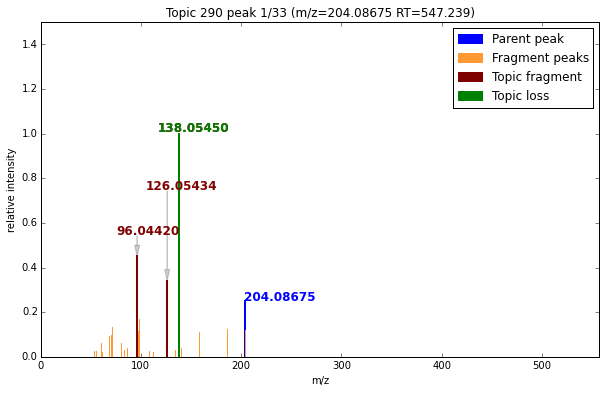

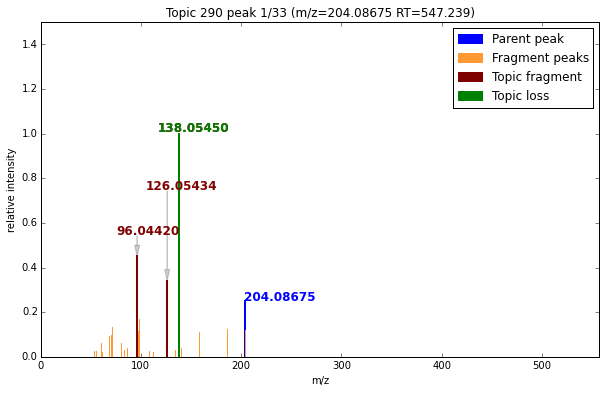

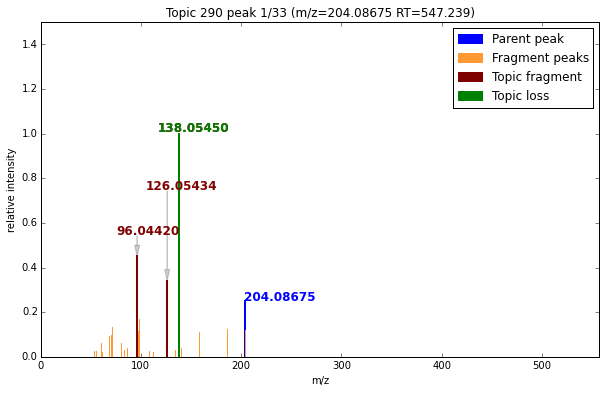

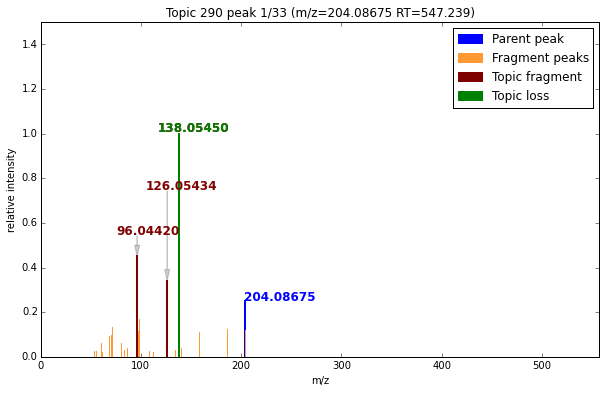

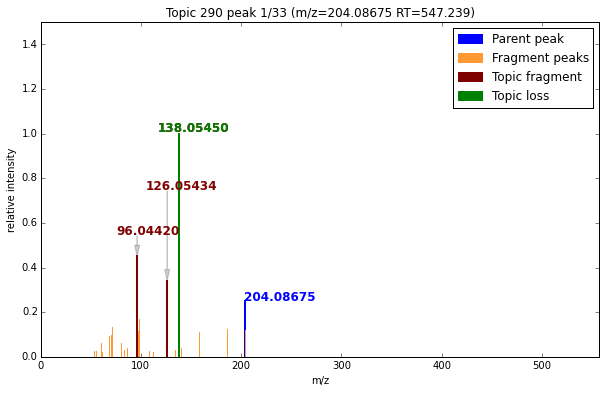

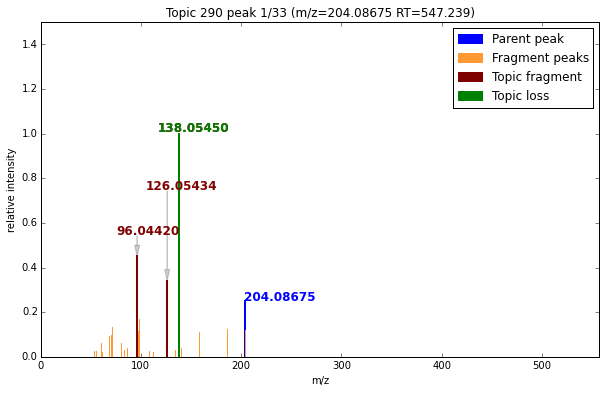

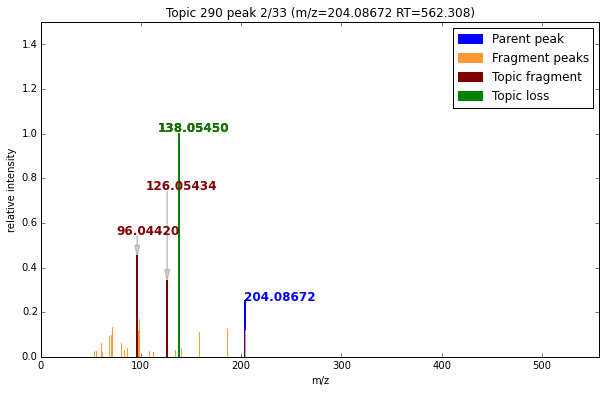

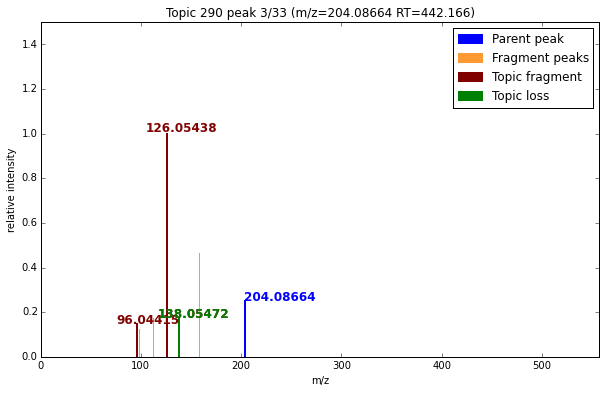

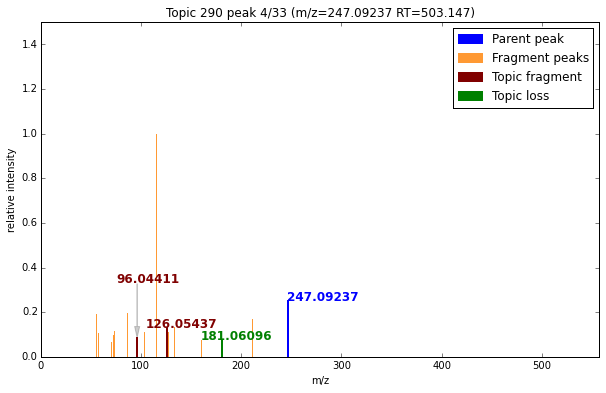

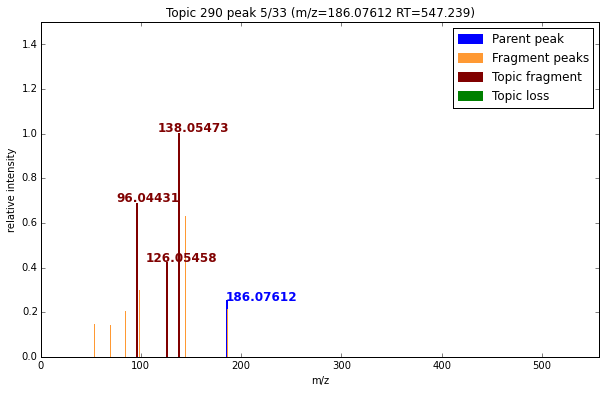

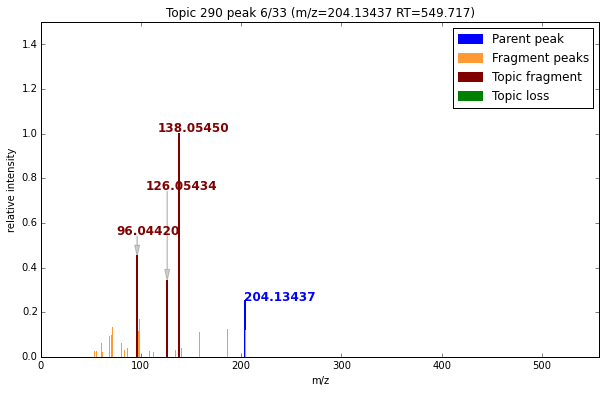

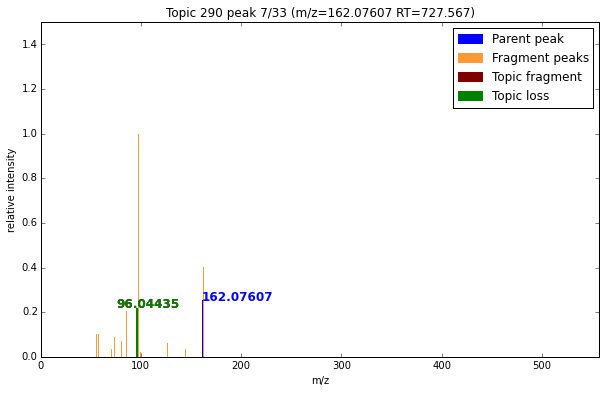

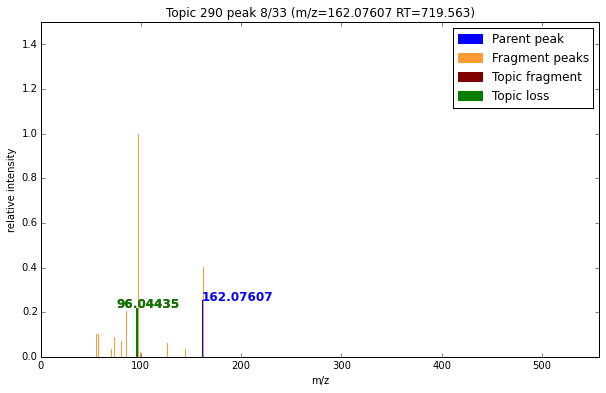

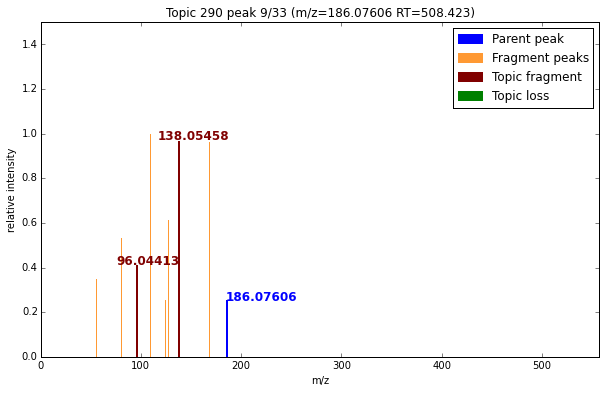

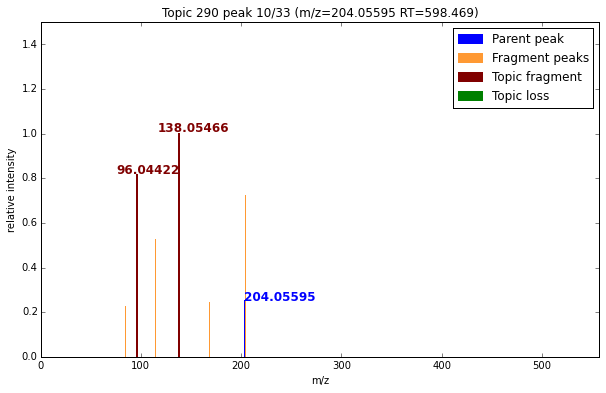

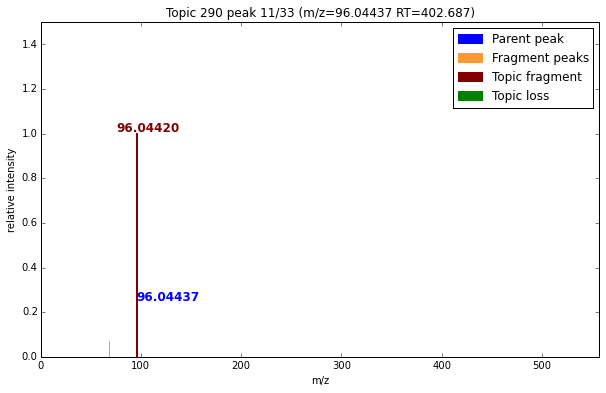

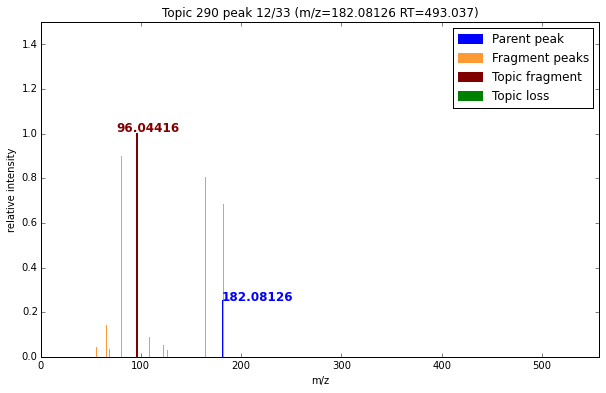

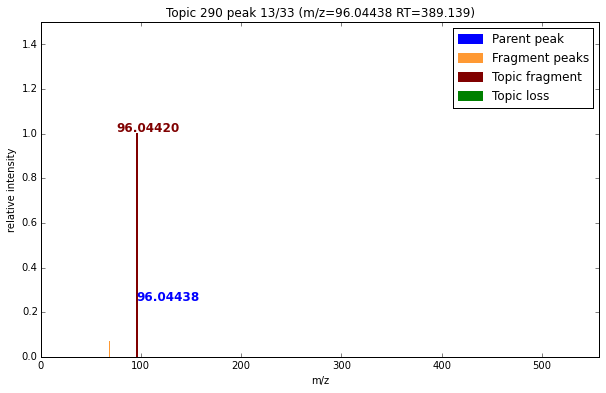

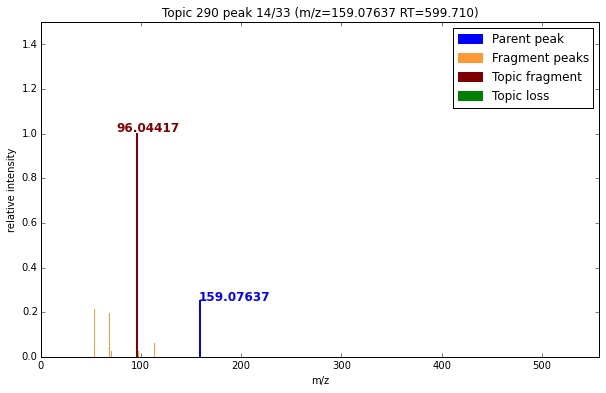

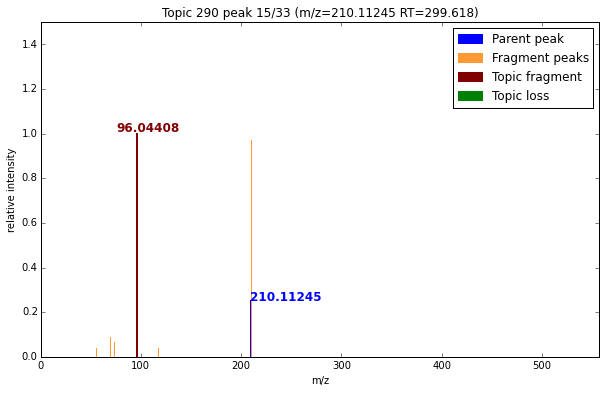

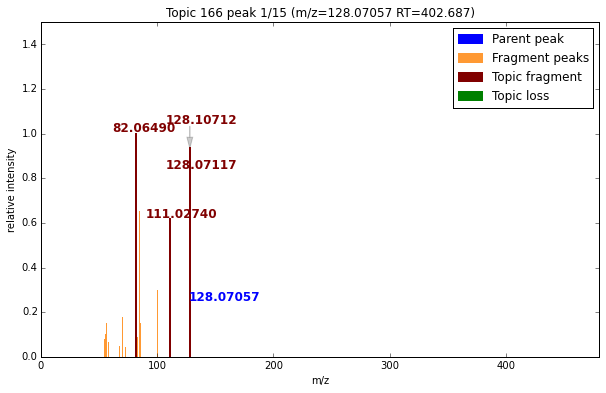

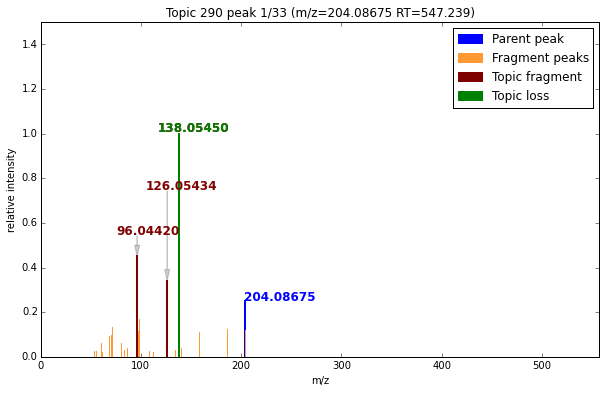

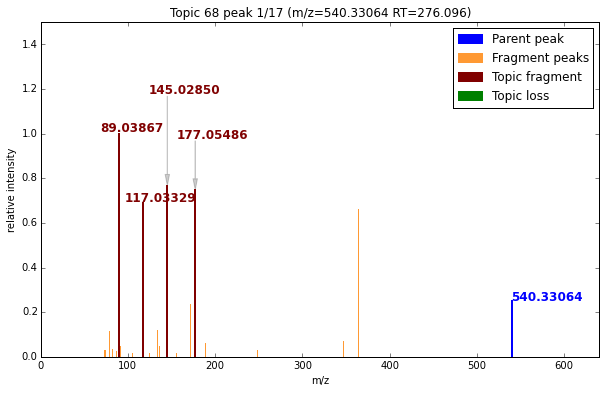

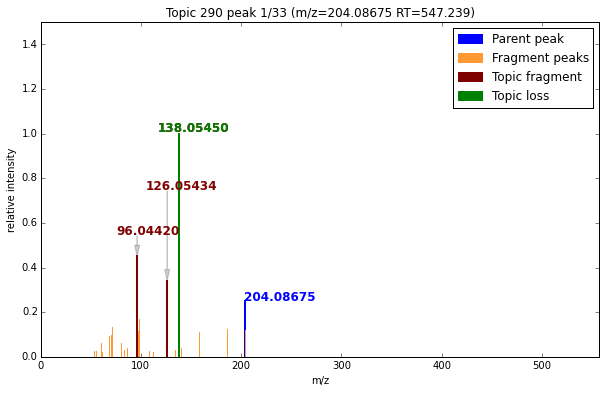

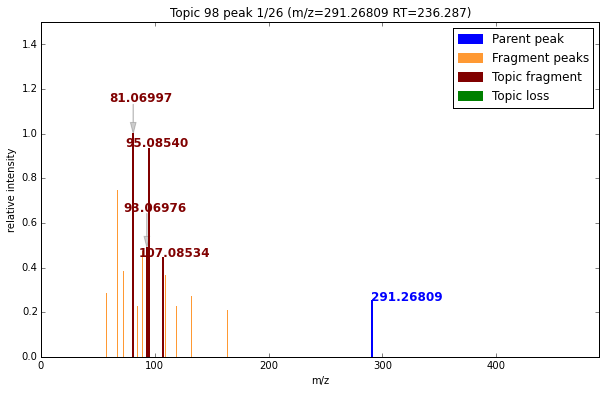

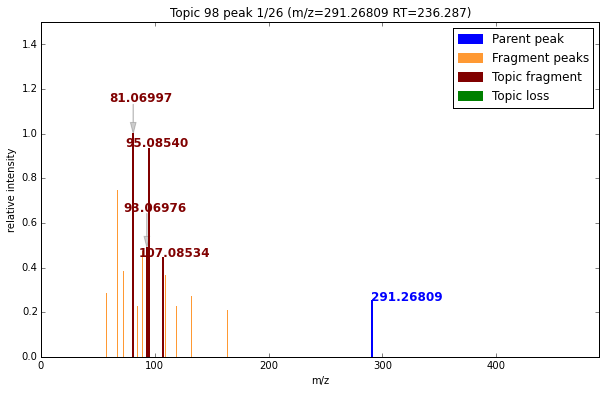

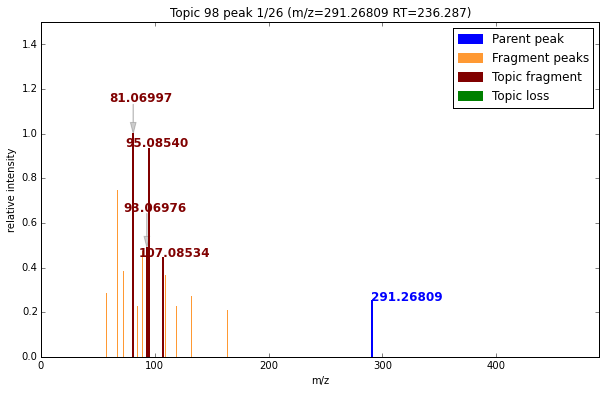

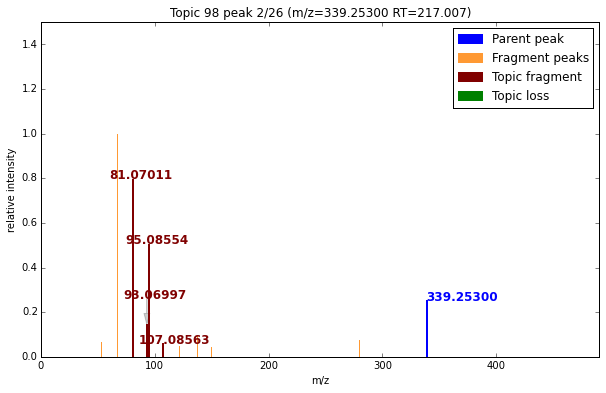

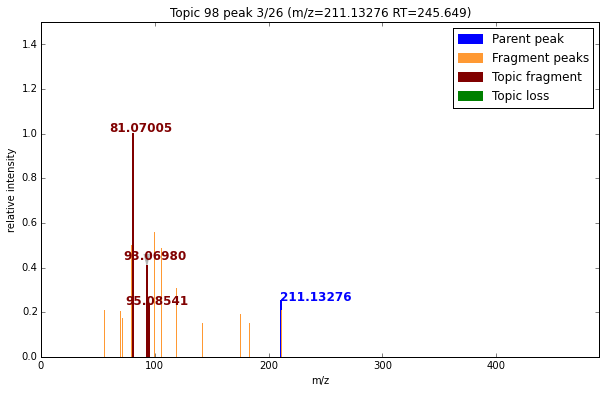

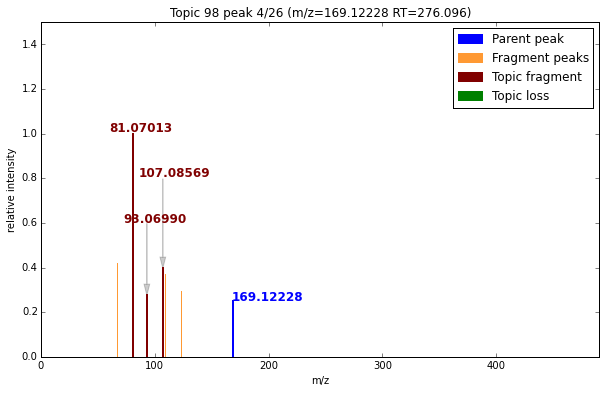

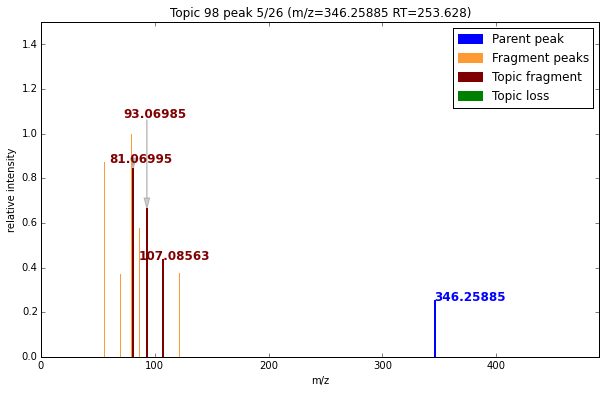

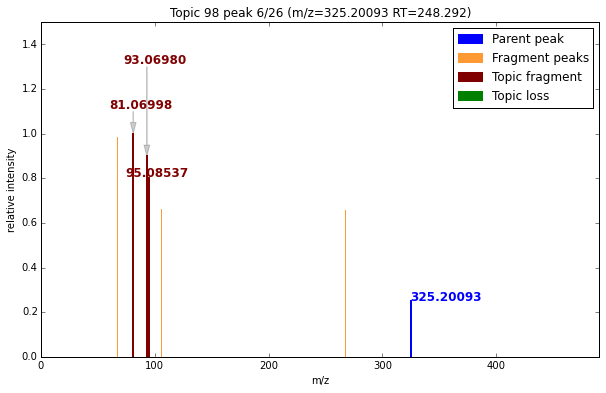

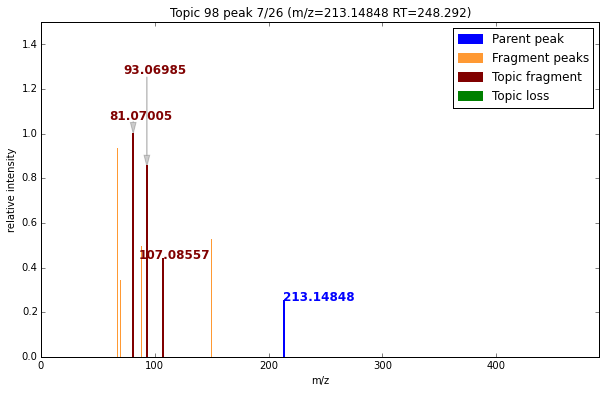

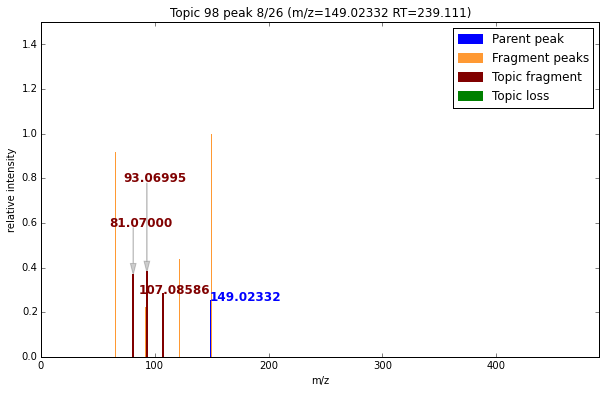

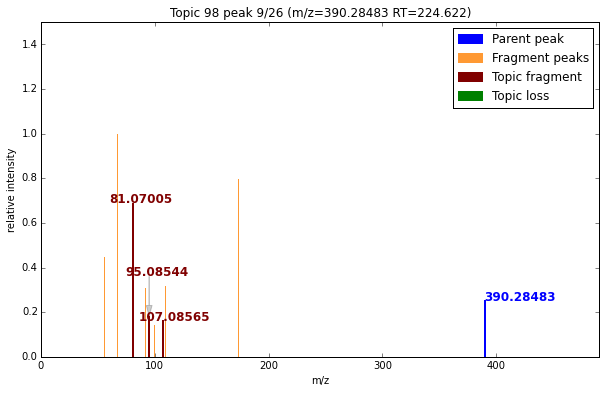

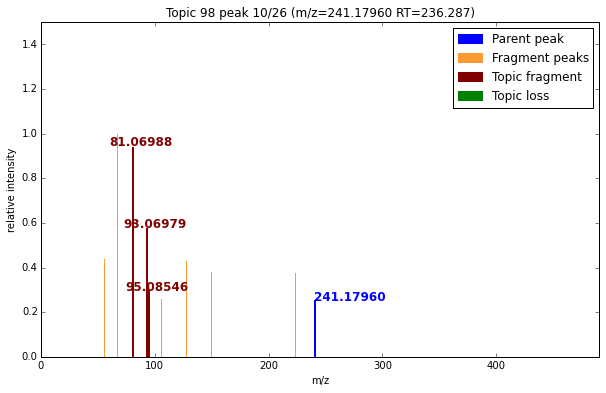

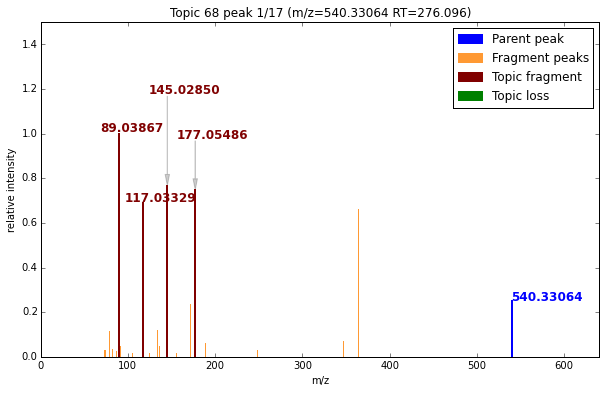

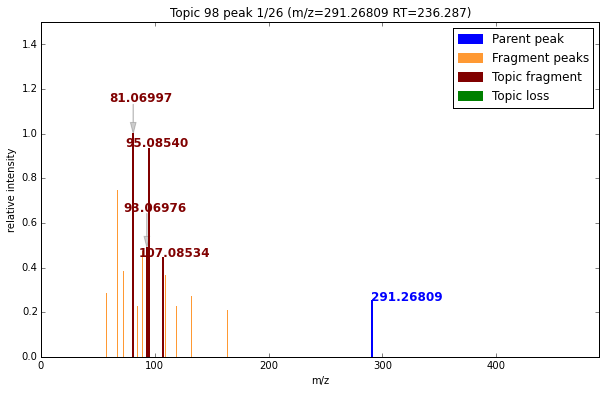

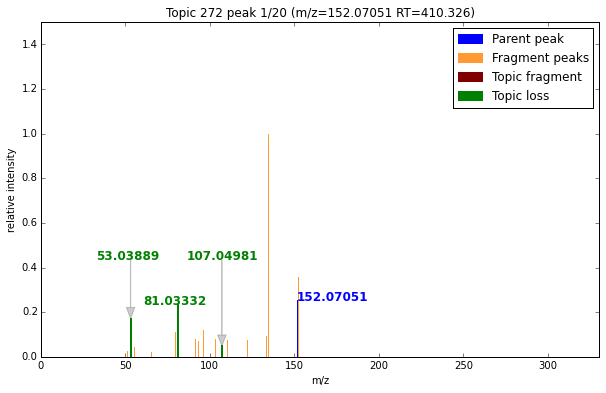

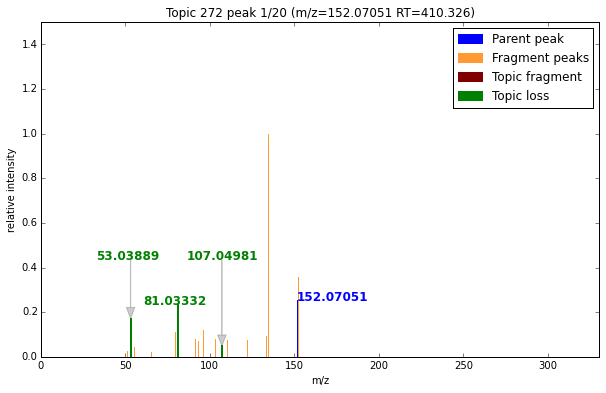

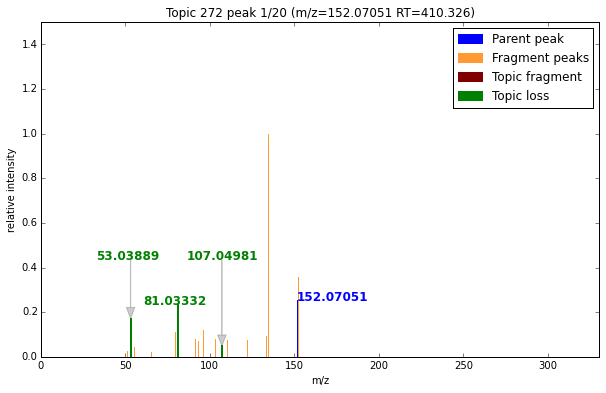

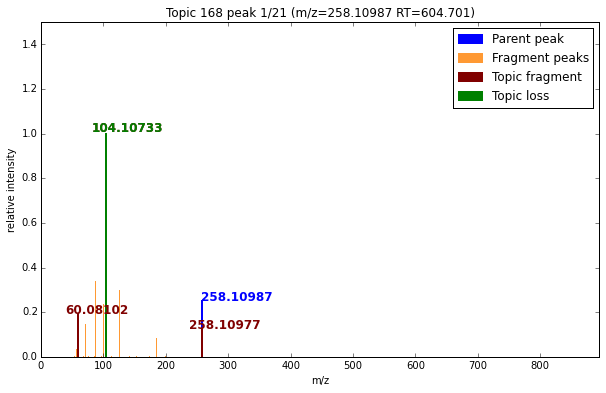

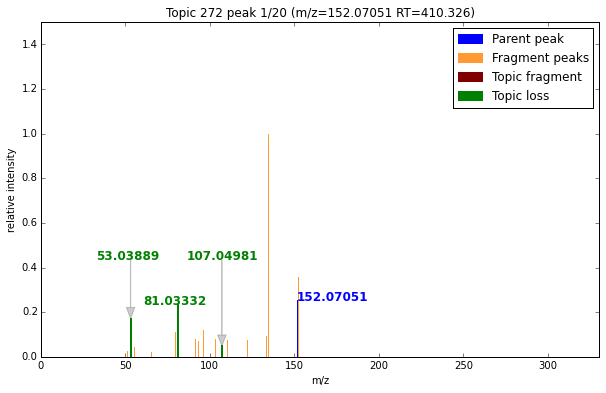

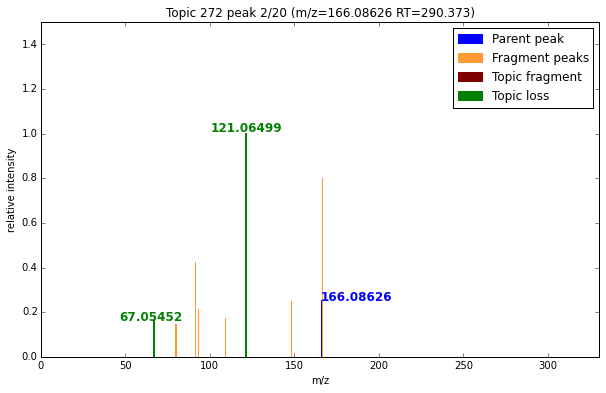

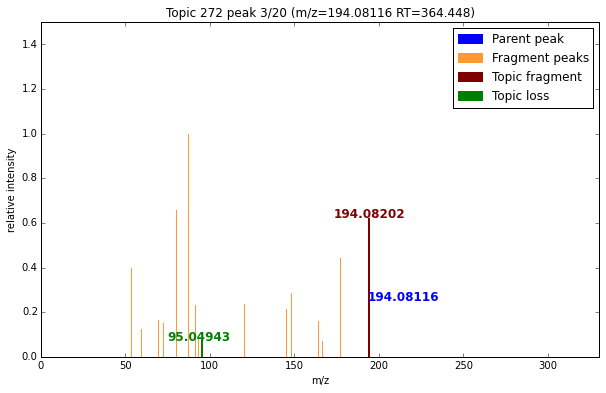

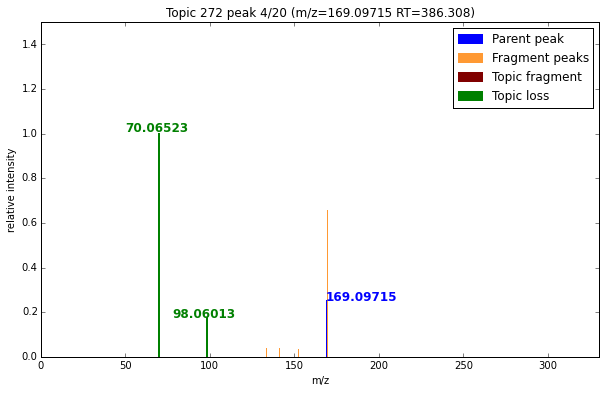

In [5]:
ms2lda.plot_lda_fragments(consistency=0.0, interactive=True, to_highlight=special_nodes)
# ms2lda.plot_lda_fragments(consistency=0.50, sort_by="in_degree")